## Dependencias

In [149]:
from functools import reduce
from itertools import combinations

import cufflinks as cf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from auxiliares import freq, normalizar
from scikitplot.metrics import plot_roc
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.linear_model import PassiveAggressiveClassifier, Perceptron
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     train_test_split)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from varclushi import VarClusHi

cf.go_offline()



## Lectura de datos

In [105]:
ruta = '/media/jose/090f6b94-de30-4aaf-9f8a-4e18b120d7f6/bd/anime/archive/anime_cleaned.csv'

In [106]:
df = pd.read_csv(ruta)

In [107]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [108]:
df.sample()

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,airing,aired_string,aired,duration,rating,score,scored_by,rank,popularity,members,favorites,background,premiered,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme,duration_min,aired_from_year
3220,34161,Overlord Movie 1: Fushisha no Ou,Overlord: The Undead King,【前編】劇場版総集編 オーバーロード 不死者の王,Gekijouban Overlord,https://myanimelist.cdn-dena.com/images/anime/12/87759.jpg,Movie,Light novel,1,Finished Airing,False,"Feb 25, 2017","{'from': '2017-02-25', 'to': '2017-02-25'}",1 hr. 42 min.,R - 17+ (violence & profanity),7.7,6994,1118.0,1989,33180,68,NaN,NaN,NaN,"{'Full story': [{'mal_id': 29803, 'type': 'anime', 'url': 'https://myanimelist.net/anime/29803/Overlord', 'title': 'Overlord'}], 'Sequel': [{'mal_id': 34428, 'type': 'anime', 'url': 'https://myanimelist.net/anime/34428/Overlord_Movie_2__Shikkoku_no_Eiyuu', 'title': 'Overlord Movie 2: Shikkoku no Eiyuu'}], 'Other': [{'mal_id': 36683, 'type': 'anime', 'url': 'https://myanimelist.net/anime/36683/Overlord_Movie__Manner_Movie', 'title': 'Overlord Movie: Manner Movie'}]}",NaN,NaN,Madhouse,"Action, Game, Supernatural, Magic, Fantasy","['""Laughter Slaughter"" by O×T (Masayoshi Oishi × Tom-H@ck)']","['""Crazy Scary Holy Fantasy"" by MYTH & ROID']",102.0,2017.0


## Definición de variables

In [109]:
varc = ['episodes','members','score','scored_by','favorites','aired_from_year','duration_min']
vard = ['rating','status','type','source','producer','studio','genre']
um = ['anime_id','title','title_english']

In [110]:
df = df[um+varc+vard]

In [111]:
df.sample(3)

,anime_id,title,title_english,episodes,members,score,scored_by,favorites,aired_from_year,duration_min,rating,status,type,source,producer,studio,genre
5572,12393,Oyako Club,NaN,1818,324,5.96,108,0,1994.0,5.0,G - All Ages,Finished Airing,TV,Original,Fuji TV,Eiken,"Slice of Life, Comedy"
3254,21573,Senki Zesshou Symphogear GX,Symphogear GX,13,24642,7.49,10176,312,2015.0,23.0,PG-13 - Teens 13 or older,Finished Airing,TV,Original,"Starchild Records, Memory-Tech, Bushiroad, MAGES., Kinyosha",Satelight,"Action, Music, Sci-Fi"
3118,2235,Mizu no Kotoba,NaN,1,18533,6.93,10903,24,2002.0,9.0,PG-13 - Teens 13 or older,Finished Airing,Special,Original,NaN,Studio Rikka,"Drama, Psychological, Sci-Fi"


In [112]:
df['target'] = (df['score']>=8)*1

In [113]:
varc.remove('score')
df.drop('score',axis=1,inplace=True)

## Partición de datos

In [114]:
train,valid = train_test_split(df,test_size=0.3)
train.reset_index(drop=True,inplace=True)
valid.reset_index(drop=True,inplace=True)
train.shape,valid.shape

((4667, 17), (2001, 17))

## Análisis Exploratorio de Datos

### Continuo

#### Ausentes

In [115]:
train[varc].isnull().sum()/len(train)

episodes           0.0
members            0.0
scored_by          0.0
favorites          0.0
aired_from_year    0.0
duration_min       0.0
dtype: float64

#### Varianza de las variables continuas

In [116]:
vt = VarianceThreshold()

vt.fit(train[varc])

varc = np.array(varc)[vt.get_support()].tolist()

len(varc),varc

(6,
 ['episodes',
  'members',
  'scored_by',
  'favorites',
  'aired_from_year',
  'duration_min'])

#### Multicolinealidad

In [117]:
vc = VarClusHi(df=train,feat_list=varc).varclus()


In [118]:
vc.rsquare

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
0,0,members,0.943764,0.004483,0.056489
1,0,scored_by,0.947695,0.002170,0.052419
2,0,favorites,0.787259,0.000466,0.212840
3,0,episodes,0.018897,0.000221,0.981320
4,1,aired_from_year,0.591899,0.008393,0.411555
5,1,duration_min,0.591899,0.000357,0.408247


In [119]:
best = sorted(vc.rsquare.sort_values(by=['Cluster','RS_Ratio']).groupby('Cluster').first()['Variable'])

#### Extremos

array([[<Axes: title={'center': 'duration_min'}>,
        <Axes: title={'center': 'scored_by'}>]], dtype=object)

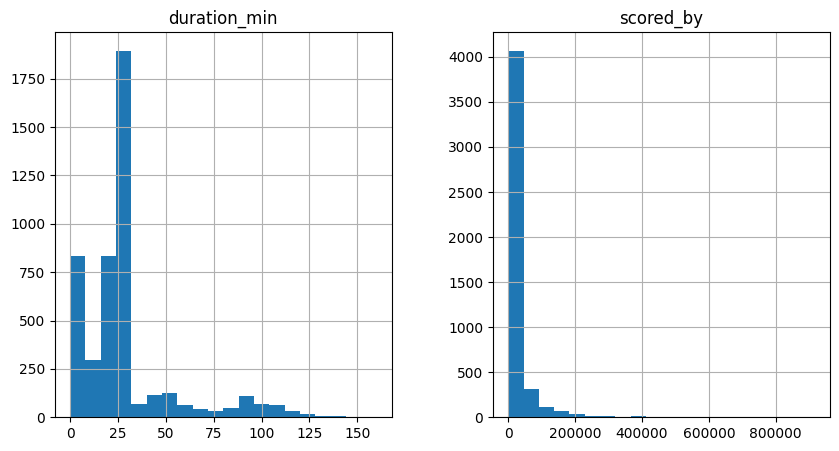

In [120]:
train[best].hist(figsize=(10,5),bins=20)

In [121]:
for v,li,ls in train[best].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values.tolist():
    train[f'ex_{v}'] = ((train[v]<li)|(train[v]>ls)).astype(int)
train['ex_'] = train.filter(like='ex_').max(axis=1)
train['ex_'].value_counts(1)

0    0.963788
1    0.036212
Name: ex_, dtype: float64

In [122]:
train = train[train['ex_']==0].reset_index(drop=True)
train = train.drop(train.filter(like='ex_').columns,axis=1)

array([[<Axes: title={'center': 'duration_min'}>,
        <Axes: title={'center': 'scored_by'}>]], dtype=object)

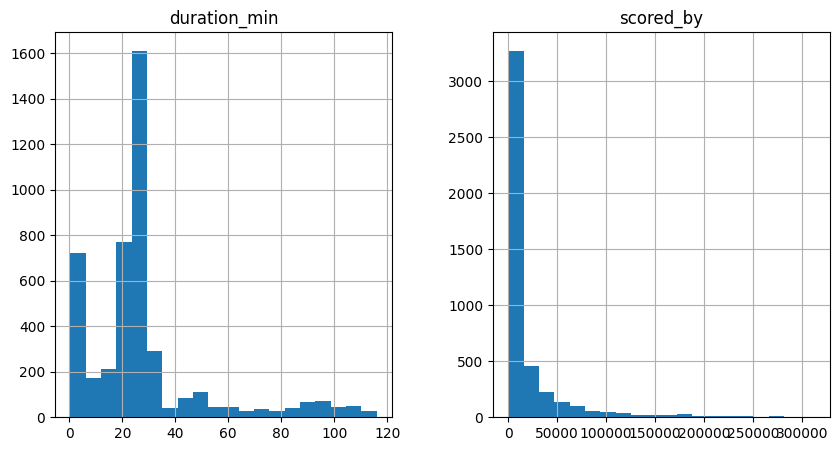

In [123]:
train[best].hist(figsize=(10,5),bins=20)

### Discreto

#### Normalización

In [124]:
for v in vard:
    train[v].fillna('MISSING',inplace=True)

In [125]:
freq(train,vard)

****Tabla de frecuencias  rating  ***


                                  FA        FR   FAA       FRA
G - All Ages                     681  0.151401   681  0.151401
None                              46  0.010227   727  0.161627
PG - Children                    340  0.075589  1067  0.237217
PG-13 - Teens 13 or older       2307  0.512895  3374  0.750111
R - 17+ (violence & profanity)   503  0.111827  3877  0.861939
R+ - Mild Nudity                 382  0.084927  4259  0.946865
Rx - Hentai                      239  0.053135  4498  1.000000




****Tabla de frecuencias  status  ***


                    FA        FR   FAA       FRA
Currently Airing   118  0.026234   118  0.026234
Finished Airing   4380  0.973766  4498  1.000000




****Tabla de frecuencias  type  ***


           FA        FR   FAA       FRA
Movie     560  0.124500   560  0.124500
Music      73  0.016229   633  0.140729
ONA       271  0.060249   904  0.200978
OVA       963  0.214095  1867  0.415073
Special   631  0.140285

In [126]:
mapa_norm = list(map(lambda v:normalizar(train,v),vard))
for v, mapa in mapa_norm:
    train[f'n_{v}'] = train[v].replace(mapa)
varn = [f'n_{v}' for v in vard]
freq(train,varn)

****Tabla de frecuencias  n_rating  ***


                                  FA        FR   FAA       FRA
G - All Ages                     681  0.151401   681  0.151401
PG - Children                    340  0.075589  1021  0.226990
PG-13 - Teens 13 or older       2353  0.523121  3374  0.750111
R - 17+ (violence & profanity)   503  0.111827  3877  0.861939
R+ - Mild Nudity                 382  0.084927  4259  0.946865
Rx - Hentai                      239  0.053135  4498  1.000000




****Tabla de frecuencias  n_status  ***


                   FA   FR   FAA  FRA
Finished Airing  4498  1.0  4498  1.0




****Tabla de frecuencias  n_type  ***


           FA        FR   FAA       FRA
Movie     560  0.124500   560  0.124500
ONA       271  0.060249   831  0.184749
OVA       963  0.214095  1794  0.398844
Special   631  0.140285  2425  0.539129
TV       2073  0.460871  4498  1.000000




****Tabla de frecuencias  n_source  ***


                FA        FR   FAA       FRA
Game           297  

####  Varianza cero (Unarias)

In [127]:
unarias = [v for v in varn if len(train[v].unique())==1]
varn = [v for v in varn if v not in unarias]
len(varn)

5

## Espacios 

### Natural $\mathcal{X}$

In [130]:
X = train[best].copy()
oh = OneHotEncoder(sparse=True, handle_unknown='ignore', drop='if_binary')
oh.fit(train[varn])
X = pd.concat([X, pd.DataFrame(oh.transform(train[varn]).toarray(),
              columns=oh.get_feature_names_out())], axis=1)
X.head()


/home/jose/entornos/amv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



,duration_min,scored_by,n_rating_G - All Ages,n_rating_PG - Children,n_rating_PG-13 - Teens 13 or older,n_rating_R - 17+ (violence & profanity),n_rating_R+ - Mild Nudity,n_rating_Rx - Hentai,n_type_Movie,n_type_ONA,n_type_OVA,n_type_Special,n_type_TV,n_source_Game,n_source_Light novel,n_source_Manga,n_source_Original,n_source_Otros,n_source_Visual novel,n_producer_Otros,n_studio_Toei Animation
0,22.0,11597,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,2.0,51,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,42.0,11061,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,12.0,3116,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,23.0,21390,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


### Espacio de híper-caja $\mathcal{X}_{[0,1]}$

In [132]:
sc01 = MinMaxScaler()
sc01.fit(X)
X01 = pd.DataFrame(sc01.transform(X),columns=X.columns)
X01.head()

,duration_min,scored_by,n_rating_G - All Ages,n_rating_PG - Children,n_rating_PG-13 - Teens 13 or older,n_rating_R - 17+ (violence & profanity),n_rating_R+ - Mild Nudity,n_rating_Rx - Hentai,n_type_Movie,n_type_ONA,n_type_OVA,n_type_Special,n_type_TV,n_source_Game,n_source_Light novel,n_source_Manga,n_source_Original,n_source_Otros,n_source_Visual novel,n_producer_Otros,n_studio_Toei Animation
0,0.187086,0.037007,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.014125,0.000140,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.360046,0.035296,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.100605,0.009927,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.195734,0.068277,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


### Espacio de componentes principales $\mathcal{X}_p$

In [137]:
pipe = make_pipeline(StandardScaler(),PCA(n_components=0.95),MinMaxScaler())
pipe.fit(X)
Xp = pd.DataFrame(pipe.transform(X))
print(pipe.steps[1][1].explained_variance_ratio_.cumsum())
Xp.head()

[0.1080782  0.20841772 0.30215767 0.38030468 0.44645823 0.50993405
 0.57272493 0.63114661 0.68516309 0.73685177 0.78384822 0.82690637
 0.86688353 0.90323697 0.93645537 0.96653925]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.492474,0.309555,0.361894,0.282243,0.430455,0.260449,0.295537,0.474538,0.411639,0.591354,0.320216,0.462650,0.309232,0.383848,0.337540,0.399530
1,0.272298,0.548157,0.131652,0.374386,0.609563,0.322417,0.184986,0.272724,0.469931,0.448014,0.385205,0.510300,0.327499,0.505698,0.628609,0.235026
2,0.408957,0.605466,0.493745,0.031177,0.297049,0.333725,0.324956,0.428701,0.737665,0.215315,0.573047,0.629379,0.495999,0.682316,0.257994,0.399365
3,0.403795,0.284262,0.148052,0.488771,0.757109,0.177428,0.257429,0.480484,0.582158,0.346837,0.478830,0.417864,0.609453,0.549300,0.454496,0.086274
4,0.211301,0.416230,0.230371,0.525265,0.643275,0.196629,0.307666,0.792914,0.432630,0.419498,0.272022,0.524725,0.372985,0.546012,0.406512,0.315134


In [138]:
Xp.corr().round(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0
1,-0.0,1.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0
3,0.0,0.0,0.0,1.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
5,-0.0,0.0,0.0,-0.0,0.0,1.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0
6,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
7,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,1.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0
8,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,1.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0
9,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,1.0,0.0,0.0,-0.0,0.0,-0.0,-0.0


## Aprendizaje

### Entrenamiento con híperparametrización

In [144]:
mod = SVC()
hp = {'C': np.arange(0.1, 2, 0.1), 'kernel': ['linear', 'rbf', 'poly'], 'gamma': [
    'scale', 'auto'], 'probability': [True],'degree':[2,3,4,5]}
print(reduce(lambda x,y:x*y,[len(hp[k]) for k in hp.keys()]))
grid = RandomizedSearchCV(mod, hp, cv=5, n_iter=20, n_jobs=-1, verbose=1,scoring='roc_auc')
grid.fit(Xp, train['target'])
print(grid.best_params_,grid.best_score_)
mod = grid.best_estimator_
mod.fit(Xp, train['target'])

456
Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'probability': True, 'kernel': 'poly', 'gamma': 'auto', 'degree': 3, 'C': 1.0} 0.8054975995389551


SVC(gamma='auto', kernel='poly', probability=True)

In [145]:
roc_auc_score(train['target'],mod.predict_proba(Xp)[:,1])

0.8377723568301049

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

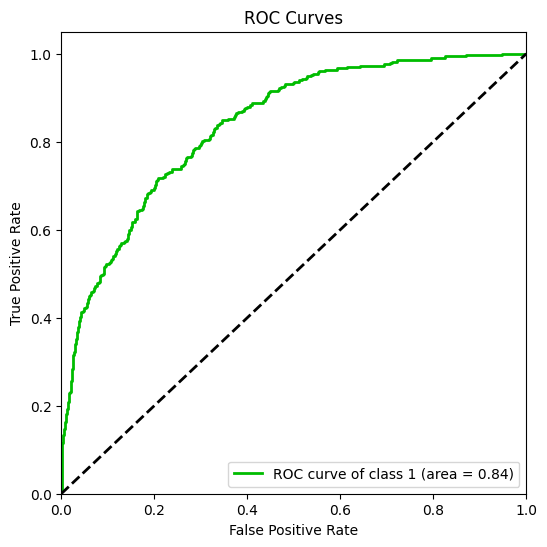

In [155]:
plot_roc(train['target'], mod.predict_proba(Xp), plot_macro=False,
         plot_micro=False, figsize=(6, 6), classes_to_plot=[1])


### Validación del modelo

In [156]:
for v, mapa in mapa_norm:
    valid[f'n_{v}'] = valid[v].replace(mapa)

****Tabla de frecuencias  n_rating  ***


                                  FA        FR   FAA       FRA
G - All Ages                     320  0.159920   320  0.159920
PG - Children                    137  0.068466   457  0.228386
PG-13 - Teens 13 or older       1049  0.524238  1506  0.752624
R - 17+ (violence & profanity)   229  0.114443  1735  0.867066
R+ - Mild Nudity                 176  0.087956  1911  0.955022
Rx - Hentai                       90  0.044978  2001  1.000000




****Tabla de frecuencias  n_type  ***


          FA        FR   FAA       FRA
Movie    284  0.141929   284  0.141929
ONA      123  0.061469   407  0.203398
OVA      373  0.186407   780  0.389805
Special  282  0.140930  1062  0.530735
TV       939  0.469265  2001  1.000000




****Tabla de frecuencias  n_source  ***


               FA        FR   FAA       FRA
Game          120  0.059970   120  0.059970
Light novel   172  0.085957   292  0.145927
Manga         738  0.368816  1030  0.514743
Original      542

In [158]:
Xv = valid[best].copy()
Xv = pd.concat([Xv, pd.DataFrame(oh.transform(valid[varn]).toarray(),
              columns=oh.get_feature_names_out())], axis=1)
Xv.head()


/home/jose/entornos/amv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning:

Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros



,duration_min,scored_by,n_rating_G - All Ages,n_rating_PG - Children,n_rating_PG-13 - Teens 13 or older,n_rating_R - 17+ (violence & profanity),n_rating_R+ - Mild Nudity,n_rating_Rx - Hentai,n_type_Movie,n_type_ONA,n_type_OVA,n_type_Special,n_type_TV,n_source_Game,n_source_Light novel,n_source_Manga,n_source_Original,n_source_Otros,n_source_Visual novel,n_producer_Otros,n_studio_Toei Animation
0,24.0,2295,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,24.0,9025,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1.0,2341,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2.0,3994,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,25.0,438250,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [159]:
Xvp = pd.DataFrame(pipe.transform(Xv))

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

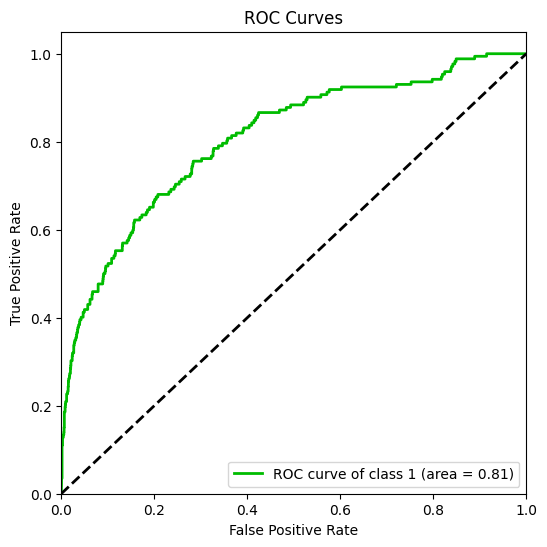

In [161]:
plot_roc(valid['target'], mod.predict_proba(Xvp), plot_macro=False,
         plot_micro=False, figsize=(6, 6), classes_to_plot=[1])


(array([1902.,   38.,   11.,   17.,   33.]),
 array([0.00144267, 0.20115413, 0.4008656 , 0.60057707, 0.80028853,
        1.        ]),
 <BarContainer object of 5 artists>)

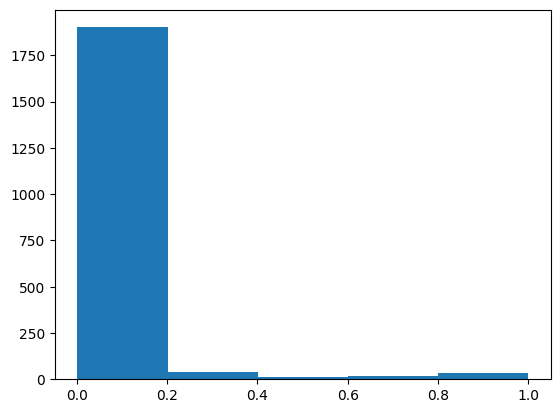

In [165]:
plt.hist(mod.predict_proba(Xvp)[:,1],bins=5)

## Reporte del modelo

In [162]:
train['r_proba'] = pd.cut(mod.predict_proba(Xp)[:,1],bins=np.arange(0,1.2,0.2)).astype(str)
valid['r_proba'] = pd.cut(mod.predict_proba(Xvp)[:,1],bins=np.arange(0,1.2,0.2)).astype(str)

In [166]:
aux = pd.concat([train[['r_proba','target']].assign(muestra='train').assign(n=1),
valid[['r_proba','target']].assign(muestra='valid').assign(n=1)],ignore_index=True)

In [170]:
aux.groupby(['r_proba','muestra','target']).agg({'n':'count'}).reset_index().to_clipboard(index=False)

## Ejemplos

In [180]:
valid[valid['r_proba']=='(0.8, 1.0]'].sort_values(by='title_english')['title_english'].to_clipboard(index=False)

In [195]:
valid[valid['r_proba']=='(0.6, 0.8]'].sort_values(by='title_english')

,anime_id,title,title_english,episodes,members,scored_by,favorites,aired_from_year,duration_min,rating,status,type,source,producer,studio,genre,target,n_rating,n_status,n_type,n_source,n_producer,n_studio,n_genre,r_proba
1533,22729,Aldnoah.Zero,Aldnoah.Zero,12,323603,184307,3415,2014.0,23.0,R - 17+ (violence & profanity),Finished Airing,TV,Original,"Aniplex, Movic, Nitroplus, Houbunsha, MAGES., Tokyo MX, Asahi Broadcasting, BS11","A-1 Pictures, TROYCA","Action, Military, Sci-Fi, Mecha",0,R - 17+ (violence & profanity),Finished Airing,TV,Original,Otros,Otros,Otros,"(0.6, 0.8]"
1823,1686,Bleach Movie 1: Memories of Nobody,Bleach the Movie: Memories of Nobody,1,176390,116685,657,2006.0,93.0,PG-13 - Teens 13 or older,Finished Airing,Movie,Manga,"TV Tokyo, Dentsu, Shueisha",Studio Pierrot,"Action, Adventure, Super Power",0,PG-13 - Teens 13 or older,Finished Airing,Movie,Manga,"TV Tokyo, Dentsu, Shueisha",Otros,"Action, Adventure, Super Power","(0.6, 0.8]"
32,4059,"Clannad: Mou Hitotsu no Sekai, Tomoyo-hen","Clannad: Another World, Tomoyo Chapter",1,193648,132514,721,2008.0,25.0,PG-13 - Teens 13 or older,Finished Airing,Special,Visual novel,Pony Canyon,Kyoto Animation,"Drama, Romance, School, Slice of Life",1,PG-13 - Teens 13 or older,Finished Airing,Special,Visual novel,Otros,Otros,Otros,"(0.6, 0.8]"
1526,22043,Fairy Tail (2014),Fairy Tail Series 2,102,402527,185951,9325,2014.0,24.0,PG-13 - Teens 13 or older,Finished Airing,TV,Manga,"TV Tokyo, Dentsu","A-1 Pictures, Bridge","Action, Adventure, Comedy, Fantasy, Magic, Shounen",1,PG-13 - Teens 13 or older,Finished Airing,TV,Manga,Otros,Otros,"Action, Adventure, Comedy, Fantasy, Magic, Shounen","(0.6, 0.8]"
1393,32282,Shokugeki no Souma: Ni no Sara,Food Wars! The Second Plate,13,392336,235613,2322,2016.0,24.0,PG-13 - Teens 13 or older,Finished Airing,TV,Manga,"Dentsu, Lantis, Mainichi Broadcasting System, KlockWorx, Showgate, Shueisha",J.C.Staff,"Ecchi, School, Shounen",1,PG-13 - Teens 13 or older,Finished Airing,TV,Manga,"Dentsu, Lantis, Mainichi Broadcasting System, KlockWorx, Showgate, Shueisha",Otros,Otros,"(0.6, 0.8]"
545,31637,"Gate: Jieitai Kanochi nite, Kaku Tatakaeri 2nd Season",GATE,12,249386,152178,1216,2016.0,23.0,R - 17+ (violence & profanity),Finished Airing,TV,Novel,"Genco, Warner Bros., KlockWorx, Showgate, Bandai Namco Games",A-1 Pictures,"Action, Military, Adventure, Fantasy",0,R - 17+ (violence & profanity),Finished Airing,TV,Otros,"Genco, Warner Bros., KlockWorx, Showgate, Bandai Namco Games",Otros,Otros,"(0.6, 0.8]"
330,777,Hellsing Ultimate,Hellsing Ultimate,10,425255,221939,13450,2006.0,50.0,R - 17+ (violence & profanity),Finished Airing,OVA,Manga,"Geneon Universal Entertainment, StudioRF Inc., Shounen Gahousha","Madhouse, Satelight, Graphinica","Action, Military, Horror, Supernatural, Vampire, Seinen",1,R - 17+ (violence & profanity),Finished Airing,OVA,Manga,"Geneon Universal Entertainment, StudioRF Inc., Shounen Gahousha","Madhouse, Satelight, Graphinica","Action, Military, Horror, Supernatural, Vampire, Seinen","(0.6, 0.8]"
1658,249,InuYasha,InuYasha,167,371313,181978,12282,2000.0,24.0,PG-13 - Teens 13 or older,Finished Airing,TV,Manga,"Yomiuri Telecasting, Shogakukan",Sunrise,"Action, Adventure, Comedy, Historical, Demons, Supernatural, Magic, Romance, Fantasy, Shounen",0,PG-13 - Teens 13 or older,Finished Airing,TV,Manga,Otros,Otros,"Action, Adventure, Comedy, Historical, Demons, Supernatural, Magic, Romance, Fantasy, Shounen","(0.6, 0.8]"
977,14467,K,K,13,400975,206756,5363,2012.0,24.0,PG-13 - Teens 13 or older,Finished Airing,TV,Original,"Starchild Records, Mainichi Broadcasting System, KlockWorx",GoHands,"Action, Super Power, Supernatural",0,PG-13 - Teens 13 or older,Finished Airing,TV,Original,"Starchild Records, Mainichi Broadcasting System, KlockWorx",Otros,Otros,"(0.6, 0.8]"
21,34599,Made in Abyss,Made in Abyss,13,326011,166905,11817,2017.0,25.0,R - 17+ (violence & profanity),Finished Airing,TV,Web manga,"Media Factory, AT-X, Takeshobo, Sony Music C